Notebook notes: this notebook essentially is building the null distribution based off the data that we have that are one month apart and saving it for later use

In [14]:
%load_ext autoreload
%autoreload 2
import glob
import torch
import re
import cv2
import numpy as np
import rasterio
import pickle
import sys
sys.path.insert(0, '../utils')
from difference_metrics import returnPredictions, returnIou, returnCafoDiff, returnClusterDiff, returnShiftDiff
sys.path.insert(0, '../models')
from unet_model import UNet

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
model = UNet(3, 2)
model.load_state_dict(torch.load('../../../saved_models/finished/model8_10_ia_data.pth'))

<All keys matched successfully>

In [3]:
prefix_dir = "../../../../../datadrive/data/raw/"
filedir07 = glob.glob(prefix_dir + 'planet_images_il-2019-07/*.tif')
filenames = [re.search(r'(?<=planet_images_il-2019-07/)[A-z0-9\-]+(?=_2019-07-01.tif)', file).group() for file in filedir07]
filenames.sort()

In [4]:
len(filenames)

229

In [5]:
filenames

['planet_loc_000-date',
 'planet_loc_001-date',
 'planet_loc_002-date',
 'planet_loc_003-date',
 'planet_loc_004-date',
 'planet_loc_005-date',
 'planet_loc_006-date',
 'planet_loc_007-date',
 'planet_loc_008-date',
 'planet_loc_009-date',
 'planet_loc_010-date',
 'planet_loc_011-date',
 'planet_loc_012-date',
 'planet_loc_013-date',
 'planet_loc_014-date',
 'planet_loc_015-date',
 'planet_loc_016-date',
 'planet_loc_017-date',
 'planet_loc_018-date',
 'planet_loc_019-date',
 'planet_loc_020-date',
 'planet_loc_021-date',
 'planet_loc_022-date',
 'planet_loc_023-date',
 'planet_loc_024-date',
 'planet_loc_025-date',
 'planet_loc_026-date',
 'planet_loc_027-date',
 'planet_loc_028-date',
 'planet_loc_029-date',
 'planet_loc_030-date',
 'planet_loc_031-date',
 'planet_loc_032-date',
 'planet_loc_033-date',
 'planet_loc_034-date',
 'planet_loc_035-date',
 'planet_loc_036-date',
 'planet_loc_037-date',
 'planet_loc_038-date',
 'planet_loc_039-date',
 'planet_loc_040-date',
 'planet_loc_041

This next block is removing images that are problematic as their dimensions are off (e.g. 350x160223)

In [6]:
filenames.remove('planet_loc_001-date') 
filenames.remove('planet_loc_026-date')
filenames.remove('planet_loc_027-date')
filenames.remove('planet_loc_038-date')
filenames.remove('planet_loc_052-date')
filenames.remove('planet_loc_060-date')
filenames.remove('planet_loc_068-date') 
filenames.remove('planet_loc_075-date')
filenames.remove('planet_loc_086-date') 
filenames.remove('planet_loc_097-date')
filenames.remove('planet_loc_101-date') 
filenames.remove('planet_loc_108-date')
filenames.remove('planet_loc_120-date')
filenames.remove('planet_loc_122-date')
filenames.remove('planet_loc_126-date')
filenames.remove('planet_loc_131-date')
filenames.remove('planet_loc_142-date') 
filenames.remove('planet_loc_148-date')
filenames.remove('planet_loc_149-date')
filenames.remove('planet_loc_161-date')
filenames.remove('planet_loc_171-date') 
filenames.remove('planet_loc_176-date')

In [7]:
#Checking for line/problematic images
"""
month_list = ['07', '08', '09']
year_list = ['19', '20']
errordict = {}
for year in year_list:
    for month in month_list:
        for file in filenames:
            with rasterio.open(prefix_dir + f'planet_images_il-20{year}-{month}/' + file + f'_20{year}-{month}-01' ".tif") as src:
                b, g, r, n = src.read()
            rgb = np.stack((r,g,b), axis=0)
            if np.prod(rgb[0].shape) > 400*400:
                errordict[file + month + '/' + year] = file
"""

'\nmonth_list = [\'07\', \'08\', \'09\']\nyear_list = [\'19\', \'20\']\nerrordict = {}\nfor year in year_list:\n    for month in month_list:\n        for file in filenames:\n            with rasterio.open(prefix_dir + f\'planet_images_il-20{year}-{month}/\' + file + f\'_20{year}-{month}-01\' ".tif") as src:\n                b, g, r, n = src.read()\n            rgb = np.stack((r,g,b), axis=0)\n            if np.prod(rgb[0].shape) > 400*400:\n                errordict[file + month + \'/\' + year] = file\n'

In [8]:
len(filenames)

207

In [15]:
iou_null = []
pixel_diff = []
cluster_diff = []
shift_diff = []
for file in filenames:    
    print(file)
    # Get predicted masks from model
    jul19 = returnPredictions(prefix_dir + 'planet_images_il-2019-07/' + file + '_2019-07-01' ".tif", model)    
    aug19 = returnPredictions(prefix_dir + 'planet_images_il-2019-08/' + file + '_2019-08-01' ".tif", model)
    sep19 = returnPredictions(prefix_dir + 'planet_images_il-2019-09/' + file + '_2019-09-01' ".tif", model)

    jul20 = returnPredictions(prefix_dir + 'planet_images_il-2020-07/' + file + '_2020-07-01' ".tif", model)
    aug20 = returnPredictions(prefix_dir + 'planet_images_il-2020-08/' + file + '_2020-08-01' ".tif", model)

    # Compute difference metrics and add them to our null
    iou_null.append(returnIou(jul19, aug19))
    iou_null.append(returnIou(aug19, sep19))
    iou_null.append(returnIou(jul20, aug20))    
    
    pixel_diff.append(returnCafoDiff(jul19, aug19))
    pixel_diff.append(returnCafoDiff(aug19, sep19))
    pixel_diff.append(returnCafoDiff(jul20, aug20))
    
    cluster_diff.append(returnClusterDiff(jul19, aug19))
    cluster_diff.append(returnClusterDiff(aug19, sep19))
    cluster_diff.append(returnClusterDiff(jul20, aug20))
    
    shift_diff.append(returnShiftDiff(jul19, aug19))
    shift_diff.append(returnShiftDiff(aug19, sep19))
    shift_diff.append(returnShiftDiff(jul20, aug20))

planet_loc_000-date
planet_loc_002-date
planet_loc_003-date
planet_loc_004-date
planet_loc_005-date
planet_loc_006-date
planet_loc_007-date
planet_loc_008-date
planet_loc_009-date
planet_loc_010-date
planet_loc_011-date
planet_loc_012-date
planet_loc_013-date
planet_loc_014-date
planet_loc_015-date
planet_loc_016-date
planet_loc_017-date
planet_loc_018-date
planet_loc_019-date
planet_loc_020-date
planet_loc_021-date
planet_loc_022-date
planet_loc_023-date
planet_loc_024-date
planet_loc_025-date
planet_loc_028-date
planet_loc_029-date
planet_loc_030-date
planet_loc_031-date
planet_loc_032-date
planet_loc_033-date
planet_loc_034-date
planet_loc_035-date
planet_loc_036-date
planet_loc_037-date
planet_loc_039-date
planet_loc_040-date
planet_loc_041-date
planet_loc_042-date
planet_loc_043-date
planet_loc_044-date
planet_loc_045-date
planet_loc_046-date
planet_loc_047-date
planet_loc_048-date
planet_loc_049-date
planet_loc_050-date
planet_loc_051-date
planet_loc_053-date
planet_loc_054-date


In [ ]:
# Saving our null distribution to pickle files

with open('../null/iou_null.p', 'wb') as f:
    pickle.dump(iou_null, f)
    
with open('../null/pixel_diff_null.p', 'wb') as f:
    pickle.dump(pixel_diff, f)
    
with open('../null/cluster_diff_null.p', 'wb') as f:
    pickle.dump(cluster_diff, f)
    
with open('../null/shift_diff_null.p', 'wb') as f:
    pickle.dump(shift_diff, f)

Now we are visualizing the resulting null distributions

In [16]:
import matplotlib.pyplot as plt
from scipy.special import logit

In [17]:
iou_null = np.array(iou_null)[np.array(iou_null) > 0.005]

Text(0.5, 1.0, 'IoU ')

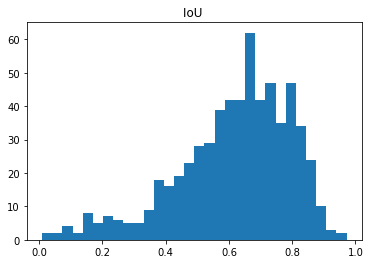

In [20]:
plt.hist(iou_null, bins=30)
plt.title("IoU ")

Text(0.5, 1.0, 'IoU Arcsin')

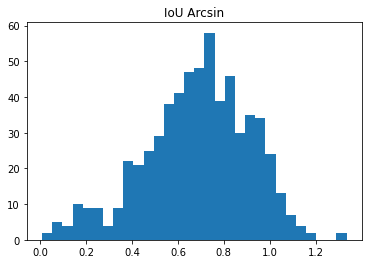

In [21]:
plt.hist(np.arcsin(iou_null), bins=30)
plt.title("IoU Arcsin")

Text(0.5, 1.0, 'Cafo Pixel Difference')

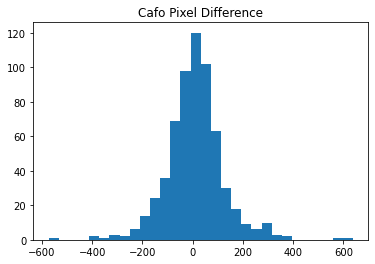

In [22]:
plt.hist(pixel_diff, bins=30)
plt.title("Cafo Pixel Difference")

Text(0.5, 1.0, 'Cluster Difference')

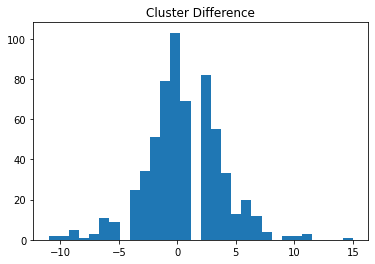

In [23]:
plt.hist(cluster_diff, bins=30)
plt.title("Cluster Difference")

Text(0.5, 1.0, 'Shift Difference')

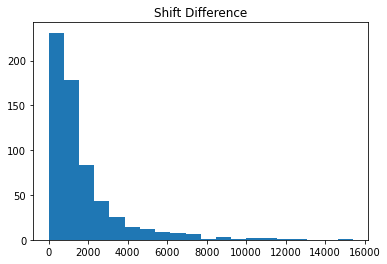

In [24]:
plt.hist(shift_diff, bins=20)
plt.title("Shift Difference")

In [ ]:
shift_diff